In [47]:
%load_ext autoreload
%autoreload 2
%env CUDA_LAUNCH_BLOCKING=1
import json
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
import torch
from scipy import stats
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data.RPF_counter_v3 import *
from data.length_bucket_dataset import *
from data.dataset_generator import DatasetGenerator
from translation_model import *
from rotary_position_embedding import *
from model_pretrain import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_LAUNCH_BLOCKING=1


## Data prepare

### load file

In [4]:
RPF_count_file = '/home/user/data3/yaoc/translation_model/model/SRR15513148_49_50_51_52.read_count.pkl'
lib_path = "/home/user/data3/rbase/translation_pred/models/lib"
tx_meta_file = lib_path + '/transcript_meta.pkl'
tx_cds_file = lib_path + '/transcript_cds.pkl'
tx_seq_file = lib_path + '/tx_seq.v48.pkl'
tx_coding_emb_file = lib_path + '/transcript_coding_embedding.pkl'

with open(tx_meta_file, 'rb') as f:
    tx_meta = pickle.load(f)
with open(tx_cds_file, 'rb') as f:
    tx_cds = pickle.load(f)
with open(RPF_count_file, 'rb') as f:
    RPF_count = pickle.load(f)
with open(tx_seq_file, 'rb') as f:
    tx_seq = pickle.load(f)
with open(tx_coding_emb_file, 'rb') as f:
    coding_emb = pickle.load(f)

In [63]:
ORF_info_dict_file = '/home/user/data3/rbase/translation_pred/models/lib/ORF/candidate_ORFs/candidateORF.60nt.tx_pos.pkl'
RPF_count_file = '/home/user/data3/yaoc/translation_model/model/SRR15513148_49_50_51_52.read_count.pkl'
with open(ORF_info_dict_file, 'rb') as f_info:
    ORF_info = pickle.load(f_info)
with open(RPF_count_file, 'rb') as f_count:
    RPF_count = pickle.load(f_count)

In [95]:
tid = "ENST00000574003.1"
ORF_info["chr17"][tid]

{'tx_len': '561',
 'strand': '+',
 'tx_type': 'canonical',
 'ORFs': [{'id': '1', 'start': '10', 'end': '331', 'start_codon': 'ATG'},
  {'id': '2', 'start': '22', 'end': '331', 'start_codon': 'TTG'},
  {'id': '3', 'start': '43', 'end': '331', 'start_codon': 'CTG'},
  {'id': '4', 'start': '52', 'end': '331', 'start_codon': 'CTG'},
  {'id': '5', 'start': '55', 'end': '331', 'start_codon': 'GTG'},
  {'id': '6', 'start': '69', 'end': '336', 'start_codon': 'TTG'},
  {'id': '7', 'start': '93', 'end': '336', 'start_codon': 'ATG'},
  {'id': '8', 'start': '97', 'end': '331', 'start_codon': 'CTG'},
  {'id': '9', 'start': '106', 'end': '331', 'start_codon': 'ATG'},
  {'id': '10', 'start': '199', 'end': '331', 'start_codon': 'GTG'},
  {'id': '11', 'start': '202', 'end': '331', 'start_codon': 'ATG'},
  {'id': '12', 'start': '213', 'end': '336', 'start_codon': 'GTG'},
  {'id': '13', 'start': '223', 'end': '331', 'start_codon': 'TTG'},
  {'id': '14', 'start': '232', 'end': '331', 'start_codon': 'GTG'}

In [11]:
# split transcripts
chrom_train = ["chr" + str(i) for i in range(1,17)] + ["X"]
chrom_valid = ["chr" + str(i) for i in range(17,21)]
chrom_test = ["chr" + str(i) for i in range(21,23)] + ["Y"]
# create data loader of transcripts
batch_size = 12
trainDatasetBatcher = LengthBucketDataset(tx_seq, tx_arrays, chrom_train, batch_size, min_length=200, max_length=2000,
                                  motif_file_path=lib_path +"/RBP_motif_annotation.tsv")
valDatasetBatcher = LengthBucketDataset(tx_seq, tx_arrays, chrom_valid, batch_size, min_length=200, max_length=2000,
                                  motif_file_path=lib_path +"/RBP_motif_annotation.tsv")

### Data Preparation ###


Data Processing: 100%|██████████| 131150/131150 [00:11<00:00, 11554.36it/s]


### Data Preparation ###


Data Processing: 100%|██████████| 29397/29397 [00:02<00:00, 10519.45it/s]


### load data

In [66]:
# data embedding
train_dataset = trainDatasetBatcher.compute_batches(RPF_count)
val_dataset = valDatasetBatcher.compute_batches(RPF_count)

Batch Processing: 100%|██████████| 1792/1792 [00:19<00:00, 91.61it/s]


### view dataset

In [102]:
idx = 5
torch.set_printoptions(threshold=np.inf)
latest_idx = len(train_dataset) - 1
raw_emb = torch.from_numpy(
    np.concatenate(
        (train_dataset[idx]["seq_emb"], train_dataset[idx]["count_emb"]), axis=2)
).to(torch.float32).cuda()
token_mask = torch.from_numpy(train_dataset[idx]["pred_mask"]).cuda() == False
masked_emb = torch.from_numpy(train_dataset[idx]["masked_emb"]).cuda()
print(raw_emb.shape)
print(token_mask.sum())
print((masked_emb * token_mask.unsqueeze(-1).float())[0,:,:4])

torch.Size([12, 331, 14])
tensor(564, device='cuda:0')
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000

In [63]:
pred_mask = torch.from_numpy(train_dataset[4]["pred_mask"]).unsqueeze(-1).repeat(1,1,14) == False
masked_emb = torch.from_numpy(train_dataset[4]["masked_emb"])
print(pred_mask.float())
print(masked_emb.shape)
masked_emb[pred_mask]=-100
print(masked_emb)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [35]:
tx_seq['ENST00000534578.5']

'ATTTTGTCCTCAGCCCCAGCAGCCGCCCGGCTGGCTGCAGAGGCCGAGGGGCCGAGGGCACCGGAGCGCAAGGGATTCCGCGGCACCACGTGTCCAAGCCGGGCTAAGGCGGGCGGAGCGGGCCGGGCCCGGCTCCCCGGGCCTGAGCGCAAACCAGCAGCGACGCGGGGTCCCGTCCGCACCGGCACCCGGCCCAGCCGGGGCCCGGTCTCCCGGGCGCACGTAGGTGCCTCCTCCTGGACAGCGCGATGGGGCCCTTCTGGGCGAGAAAGGGTGCCTCCTCCTGGACGGCGGCAGCGGCGGCGCGAGGAGCCGGCGGGCAGCGGCGCGATGGGGCCCCTCCGCGAGAGCAAGAAGGAGCACAGAGTGCAGCATCATGACAAGGAGATTTCTCGAAGCCGAATTCCCCGGTTGATTCTTCGGCCCCATATGCCCCAACAACAGCACAAAGTGTCCCCAGCCTCTGAGTCTCCTTTCTCTGAGGAAGAGAGCAGAGAGTTCAACCCCAGCAGCTCTGGGCGCTCAGCGAGGACCGTTAGCAGCAACAGCTTCTGCTCAG'

In [ ]:
loss = nn.CrossEntropyLoss()
loss(train_dataset[3]["seq_embeddings"], train_dataset[3]["masked_embedding"])

## Test Positonal Encoding (PE)

### Sinusoidal PE

In [5]:
d_model = train_x.shape[-1]
## parallel in 2 gpu
pe = nn.DataParallel(PositionalEncoding(d_model,  max_seq_length=20000), device_ids=[0,1]).cuda()
train_x_pos_em = pe(train_x)
print("Test positional_encoding. PE value:\n", train_x_pos_em)
del pe
torch.cuda.empty_cache()

Test positional_encoding. PE value:
 tensor([[[ 0.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.5403e+00,  2.5116e-02,  9.9968e-01,  6.3096e-04],
         [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  1.9987e+00,  1.2619e-03],
         ...,
         [-8.7327e-01,  1.4872e+00, -7.6240e-01, -6.4710e-01,  5.4314e-01],
         [ 9.3817e-01,  9.9809e-01, -7.7841e-01, -6.2775e-01,  5.4367e-01],
         [ 8.0645e-01,  5.9130e-01, -7.9394e-01,  3.9200e-01,  5.4420e-01]],

        [[ 0.0000e+00,  2.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.5403e+00,  2.5116e-02,  9.9968e-01,  6.3096e-04],
         [ 9.0930e-01,  5.8385e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
         ...,
         [-8.7327e-01,  4.8724e-01,  2.3760e-01, -6.4710e-01,  5.4314e-01],
         [ 9.3817e-01,  9.9809e-01, -7.7841e-01, -6.2775e-01,  5.4367e-01],
         [ 1.8065e+00,  5.9130e-01, -7.9394e-01, -6.0800e-01,  5.4420e-01]],

        [[ 1.0000e+

### Rotary PE

In [171]:
test_x = torch.from_numpy(train_dataset[0]["masked_embedding"]).to(torch.float32).cuda()
print(test_x.shape)
d_model = test_x.shape[2]
seq_len = test_x.shape[1]
RoPE = LlamaRotaryEmbeddingExt(d_model).cuda()
cos, sin = RoPE.cos_sin_cached(seq_len)
test_x_ro = RoPE(test_x.unsqueeze(1))
print(test_x_ro.shape)

torch.Size([12, 1688, 14])
torch.Size([12, 1, 1688, 14])


<Axes: >

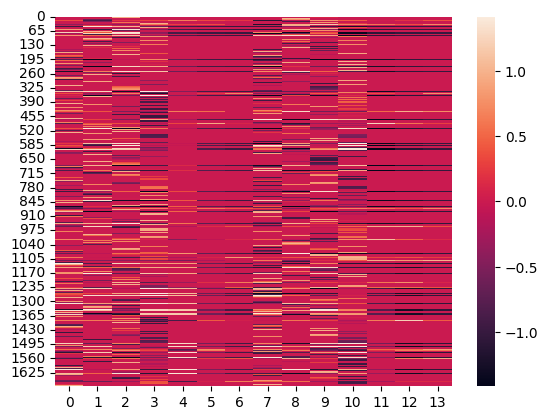

In [172]:
sns.heatmap(test_x_ro[0].squeeze(0).cpu())

<Axes: >

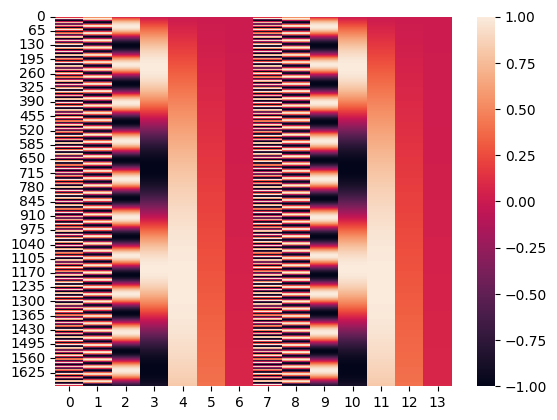

In [174]:
sns.heatmap(sin.squeeze([0,1]).cpu())

<Axes: >

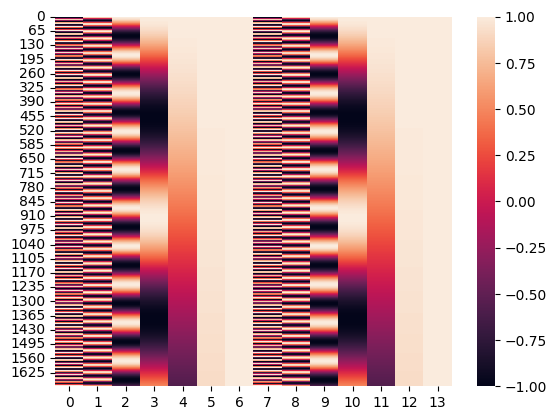

In [168]:
sns.heatmap(cos.squeeze([0,1]).cpu())

## Test Multi-HeadedAttention

In [18]:
bs, seq_len, d_model = train_x.shape
heads=1
multi_headed_attention = nn.DataParallel(MultiHeadedAttention(d_model, heads), device_ids=[0,1]).cuda()
model_output = multi_headed_attention(train_x, mask)
print(f"Test multi_head_attention. Input shape:{(bs, seq_len, d_model)} Output shape: {model_output.shape}")
print(model_output)
del multi_headed_attention
torch.cuda.empty_cache()

Test multi_head_attention. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[-7.0120e-02, -1.3909e-01,  2.4331e-02,  ...,  9.1265e-02,
          -4.6516e-02, -2.7591e-01],
         [-6.9385e-02, -1.3957e-01,  2.5595e-02,  ...,  9.1447e-02,
          -4.5032e-02, -2.7638e-01],
         [-6.9843e-02, -1.3915e-01,  2.5082e-02,  ...,  9.1335e-02,
          -4.5627e-02, -2.7614e-01],
         ...,
         [-6.9407e-02, -1.3789e-01,  2.5057e-02,  ...,  9.0888e-02,
          -4.5509e-02, -2.7592e-01],
         [-6.8431e-02, -1.3802e-01,  2.6138e-02,  ...,  9.0902e-02,
          -4.4189e-02, -2.7628e-01],
         [-6.8461e-02, -1.3804e-01,  2.6132e-02,  ...,  9.0914e-02,
          -4.4200e-02, -2.7628e-01]],

        [[-1.0279e-01, -1.4976e-01,  6.9192e-03,  ...,  9.7420e-02,
          -7.0310e-02, -2.7168e-01],
         [-1.0472e-01, -1.5007e-01,  6.5849e-03,  ...,  9.7783e-02,
          -7.0874e-02, -2.7158e-01],
         [-1.0462e-01, -1.5023e-01,  5.9103e-03, 

## Test Flash Multi-Headed Attention

In [19]:
bs, seq_len, d_model = train_x.shape
heads=1
flash_multi_headed_attention = nn.DataParallel(FlashMultiHeadedAttention(d_model, heads), device_ids=[0,1]).cuda()
model_output = flash_multi_headed_attention(train_x, mask)
print(f"Test multi_head_attention. Input shape:{(bs, seq_len, d_model)} Output shape: {model_output.shape}")
print(model_output)

Test multi_head_attention. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[ 0.2295, -0.2902,  0.1481,  ...,  0.1214, -0.1621,  0.2169],
         [ 0.2292, -0.2906,  0.1479,  ...,  0.1209, -0.1620,  0.2166],
         [ 0.2280, -0.2893,  0.1475,  ...,  0.1208, -0.1627,  0.2174],
         ...,
         [ 0.2285, -0.2910,  0.1471,  ...,  0.1203, -0.1622,  0.2160],
         [ 0.2282, -0.2909,  0.1465,  ...,  0.1203, -0.1617,  0.2157],
         [ 0.2282, -0.2909,  0.1465,  ...,  0.1203, -0.1617,  0.2157]],

        [[ 0.2127, -0.2949,  0.1326,  ...,  0.1060, -0.1672,  0.2125],
         [ 0.2122, -0.2945,  0.1312,  ...,  0.1060, -0.1672,  0.2129],
         [ 0.2131, -0.2950,  0.1320,  ...,  0.1065, -0.1666,  0.2125],
         ...,
         [ 0.2127, -0.2957,  0.1309,  ...,  0.1055, -0.1673,  0.2130],
         [ 0.2118, -0.2951,  0.1306,  ...,  0.1053, -0.1672,  0.2125],
         [ 0.2130, -0.2959,  0.1307,  ...,  0.1057, -0.1675,  0.2133]],

        [[ 0.2132, -0

## Test Encoder

In [22]:
bs, seq_len, d_model = train_x.shape
heads=1
p_prob=0.1
number_of_layers=5
dff = 1024

In [25]:
encoder_layer = EncoderLayer(d_model, dff, heads, p_prob, True)
encoder = nn.DataParallel(Encoder(encoder_layer, number_of_layers), device_ids=[0,1]).cuda()
pred_representations_batch = encoder(train_x, mask)
print(f"Test Encode. Input shape:{(bs, seq_len, d_model)} Output shape: {pred_representations_batch.shape}")
print(pred_representations_batch)
del encoder
torch.cuda.empty_cache()

Test Encode. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[ 1.3403, -1.1815, -1.7278,  ..., -0.9166,  0.2227, -0.2854],
         [ 0.7343, -1.4095, -1.2670,  ..., -0.9674,  0.2945, -0.0094],
         [ 0.8399, -1.1883, -1.4556,  ..., -1.0769,  0.0964,  0.0886],
         ...,
         [ 1.1870, -1.3721, -1.5971,  ..., -0.6740, -0.0712, -0.3368],
         [ 1.2461, -1.4847, -0.9633,  ..., -0.9224,  0.5574, -0.3363],
         [ 0.5637, -1.4828, -1.1031,  ..., -0.7438,  0.3912,  0.0270]],

        [[ 0.9993, -0.8298, -1.8089,  ..., -0.4934,  0.2696, -0.3985],
         [ 1.0281, -0.9724, -1.5167,  ..., -1.1059,  0.3324, -0.2711],
         [ 1.2634, -1.2443, -1.7876,  ..., -0.7373,  0.4715, -0.6178],
         ...,
         [ 0.7409, -1.2236, -1.7228,  ..., -0.3285,  0.0114, -0.2346],
         [ 1.1846, -1.1943, -1.6088,  ..., -1.0768,  0.5622,  0.0157],
         [ 0.8878, -1.1023, -1.6752,  ..., -0.3402,  0.1408, -0.5048]],

        [[ 0.8895, -0.8472, -1.8011

## Train Encoder-only Transformer Model

### model prepare

In [14]:
# Create model
bs, seq_len, d_input = train_dataset[0]["masked_emb"].shape
max_seq_len = max(x['length'] for x in train_dataset)
d_model = 32
dff = 2048
heads = 4
number_of_layers = 12
encoder_transformer = EncoderOnlyTransformer(
    d_input, d_model, dff, heads, 
    number_of_layers, max_seq_len, 
    PE="RoPE", flash_attn=True).cuda(rank)
encoder_transformer = DDP(encoder_transformer, device_ids=[rank], output_device=rank)

### train model

In [20]:
# Define the training parameters
lr = 0.001
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
epoch_num = 100
trainer = Trainer(
    model = encoder_transformer,
    model_name = "ribomodel.max_2000.loss_by_seq",
    dataset = train_dataset,
    checkpoint_dir = '/home/user/data3/rbase/translation_pred/models/checkpoint',
    log_dir = '/home/user/data3/rbase/translation_pred/models/log',
    world_size = world_size,
    rank = rank,
    resume = True,
    epoch_num = epoch_num,
    learning_rate = lr,
    warmup_perc = 0.3,
    accumulation_steps = 5,
    beta = (beta_1, beta_2),
    epsilon = epsilon
)

In [ ]:
trainer.pretrain(val_dataset)

==> No checkpoint found, training from scratch.
==> Training start from epoch 1


Epoch 1, training...:  10%|▉         | 650/6744 [01:44<16:23,  6.20it/s]

## Loss

### pretrain loss

In [81]:
log_dir = '/home/user/data3/rbase/translation_pred/models/log/pretrain/'
figure_dir = '/home/user/data3/rbase/translation_pred/models/test/figures/'
def pretrain_loss_plot(file_path, output_path, tasks=["seq", "count", "tissue"]):
    with open(file_path, 'r') as f_epoch:
        epoch_data = json.load(f_epoch)
    epoch_train_loss = [x['train_loss'] for x in epoch_data]
    epoch_val_loss = [x['valid_loss'] for x in epoch_data]
    # sequence loss
    if "seq" in tasks:
        seq_loss_df = pd.DataFrame(
            data={
                "epoch": [i for i, data in enumerate(epoch_train_loss)],
                "train": [i[0] for i in epoch_train_loss],
                "valid": [i[0] for i in epoch_val_loss]}
        ).melt(
            id_vars='epoch', value_vars=['train', 'valid'],
            var_name='mode', value_name='loss'
        )
        min_seq_val_loss = min(seq_loss_df[seq_loss_df["mode"]=="valid"].loss)
        
        # plot
        fig, ax = plt.subplots(figsize=(6,4))
        sns.lineplot(seq_loss_df, x="epoch", y="loss", hue="mode")
        plt.axhline(min_seq_val_loss, color="gray", linestyle=":")
        ax.set_title("Pre-training for sequence")
        fig.savefig(output_path + "pretrain_seq_loss.pdf")
    
    # count loss
    if "count" in tasks:
        count_loss_df = pd.DataFrame(
            data={
                "epoch": [i for i, data in enumerate(epoch_train_loss)],
                "train":[i[1] for i in epoch_train_loss], 
                "valid": [i[1] for i in epoch_val_loss]}
        ).melt(
            id_vars='epoch', value_vars=['train', 'valid'],
            var_name='mode', value_name='loss'
        )
        min_count_val_loss = min(count_loss_df[count_loss_df["mode"]=="valid"].loss)
    
        fig, ax = plt.subplots(figsize=(6,4))
        sns.lineplot(count_loss_df, x="epoch", y="loss", hue="mode")
        plt.axhline(min_count_val_loss, color="gray", linestyle=":")
        ax.set_title("Pre-training for RPF")
        fig.savefig(output_path + "pretrain_count_loss.pdf")
    
    # count loss
    if "tissue" in tasks:
        tissue_loss_df = pd.DataFrame(
            data={
                "epoch": [i for i, data in enumerate(epoch_train_loss)],
                "train":[i[2] for i in epoch_train_loss], 
                "valid": [i[2] for i in epoch_val_loss]}
        ).melt(
            id_vars='epoch', value_vars=['train', 'valid'],
            var_name='mode', value_name='loss'
        )
        min_tissue_val_loss = min(tissue_loss_df[tissue_loss_df["mode"]=="valid"].loss)
    
        fig, ax = plt.subplots(figsize=(6,4))
        sns.lineplot(tissue_loss_df, x="epoch", y="loss", hue="mode")
        plt.axhline(min_tissue_val_loss, color="gray", linestyle=":")
        ax.set_title("Pre-training for tissue")
        fig.savefig(output_path + "pretrain_tissue_loss.pdf")
    #plt.close(fig)

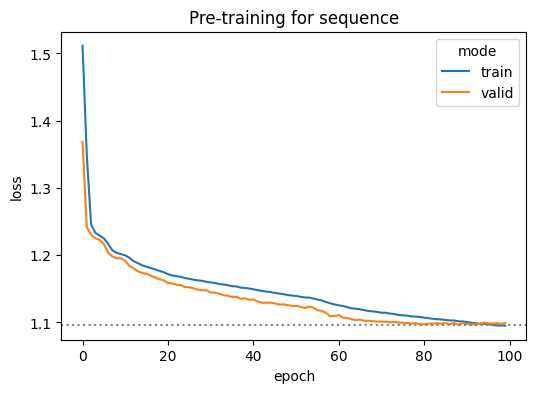

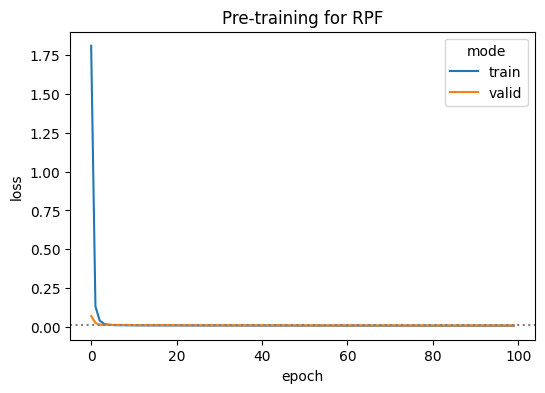

In [106]:
# only FFN as mask head
pretrain_loss_plot(log_dir + "ribomodel.max_2000.dual_loss.0.001.0.3.5.epoch_data.json",
                  figure_dir, ['seq', 'count'])

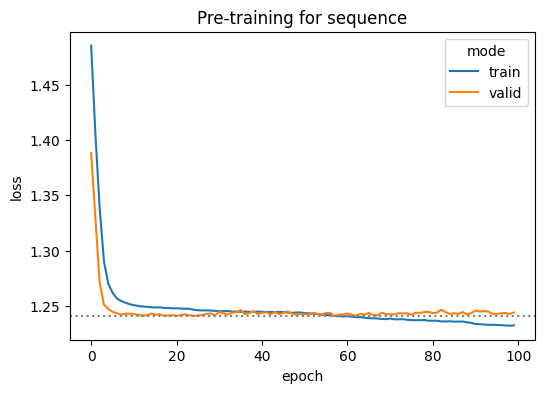

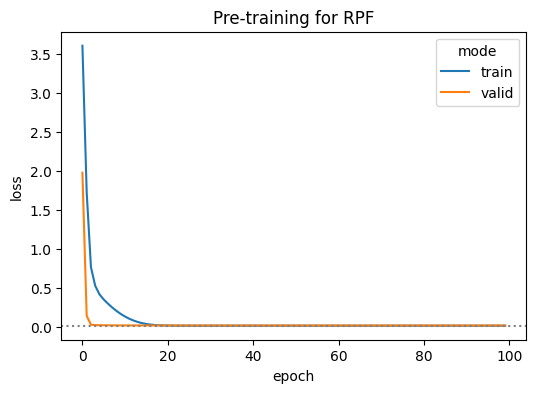

In [111]:
# 2 transformer as mask head
pretrain_loss_plot(log_dir + "ribomodel.max_2000.dual_tasks.0.001.0.3.5.epoch_data.json",
                  figure_dir, ['seq', 'count'])

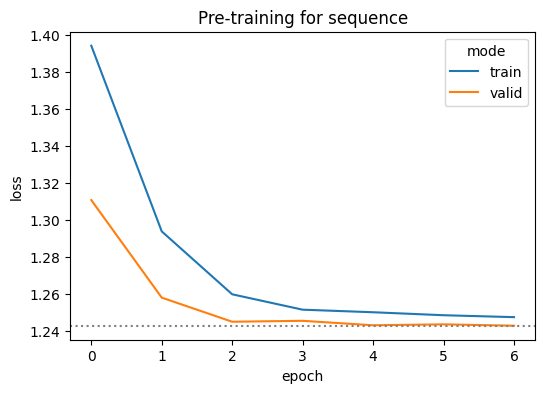

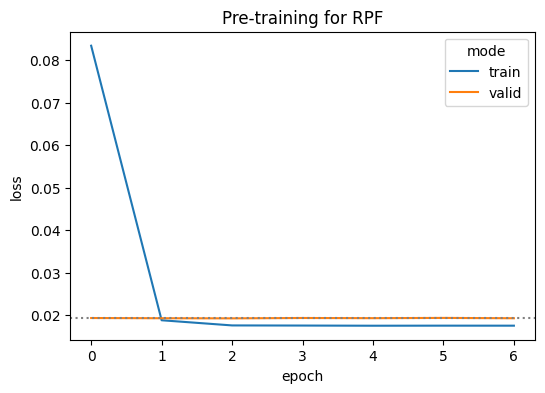

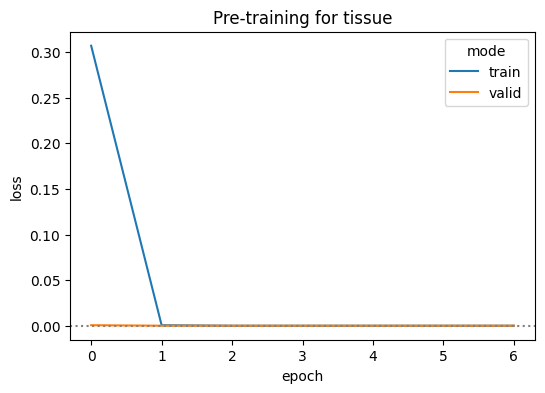

In [83]:
# only FFN, 3 tasks
pretrain_loss_plot(log_dir + "ribomodel_8h_256.max_2000.less_seq_pred.MTL.0.0005.0.3.2.epoch_data.json",
                  figure_dir, ['seq', 'count', 'tissue'])

### fine-tuning loss

In [58]:
def finetune_loss_plot(file_path, output_path):
    with open(file_path, 'r') as f_epoch:
        epoch_data = json.load(f_epoch)
    epoch_train_loss = [x['train_loss'] for x in epoch_data]
    epoch_val_loss = [x['valid_loss'] for x in epoch_data]
    # sequence loss
    loss_df = pd.DataFrame(
        data={
            "epoch": [i for i, data in enumerate(epoch_train_loss)],
            "train": epoch_train_loss,
            "valid": epoch_val_loss
        }
    ).melt(
        id_vars='epoch', value_vars=['train', 'valid'],
        var_name='mode', value_name='loss'
    )
    min_val_loss = min(loss_df[loss_df["mode"]=="valid"].loss)
    
    # plot
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(loss_df, x="epoch", y="loss", hue="mode")
    plt.axhline(min_val_loss, color="gray", linestyle=":")
    ax.set_title("Fine-Tuning")
    fig.savefig(output_path + "fine_tune_loss.pdf")
    # plt.close(fig)

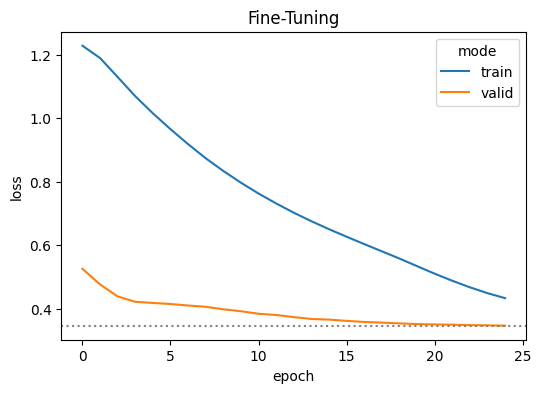

In [59]:
finetune_loss_plot(
    log_dir + "fine_tune/ribomodel.max_2000.dual_tasks.0.0001.0.2.5.epoch_data.json",
    figure_dir)

## Predict

### model load

In [8]:
torch.set_printoptions(profile="full")
ckpt = torch.load('/home/user/data3/rbase/translation_pred/models/checkpoint/pretrain/ribomodel_8h_256.max_2000.MTL.best.pt', 
                  map_location='cuda' if torch.cuda.is_available() else 'cpu')
num_tissues = 4
model = EncoderOnlyTransformer(
    d_seq = 4, 
    d_count = 10, 
    d_model = 256,
    pmt_len = 3,
    num_tissues = len(tissue_types),
    d_ff = 2048, 
    heads = 8,
    number_of_layers = 12, 
    max_seq_len = 2000, 
    PE = "RoPE"
    ).cuda()
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

### data

In [68]:
chrom_valid = ["chr" + str(i) for i in range(17,21)]
tissue_types = ["HEK293 cell", "HEK293T cell", "HeLa cell", "brain"]
val_dataset_grt = DatasetGenerator(tx_seq, tx_meta, tx_cds, chrom_valid, 
                                   all_tissue_types=tissue_types, min_length=200, max_length=2000, 
                                   motif_file_path=lib_path +"/RBP_motif_annotation.v1.tsv")
val_dataset = val_dataset_grt.generate_dataset(RPF_count, coding_emb, "brain")

### Data Cache ###


Dataset generating: 100%|██████████| 42159/42159 [00:21<00:00, 1927.92it/s]


In [1]:
for i in range(val_dataset.__len__()):
    if val_dataset.get_identifier(i) == "ENST00000574003.1":
        print(i)
        print(val_dataset.__getitem__(i)[0].shape)
        print(val_dataset.__getitem__(i)[1])
        print(val_dataset.__getitem__(i)[2].shape)
        print(val_dataset.__getitem__(i)[2][:,0].sum()/len(val_dataset.__getitem__(i)[2][:,0]))

NameError: name 'val_dataset' is not defined

In [55]:
target_tokens = val_dataset[647][0][1][260:310,:]
print(target_tokens)
masked_inp = copy.deepcopy(val_dataset[647][0][1])
masked_inp[260:310,:] = 0
print(masked_inp.unsqueeze(0).size())

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.3823, 0.7002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.2334, 0.9340, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0

In [59]:
output_seq_count, output_tissue = model(
    torch.cat((val_dataset[647][0][0], masked_inp), axis=-1).unsqueeze(0).cuda(),
    torch.tensor([3], dtype=torch.long).cuda(),
    (val_dataset[647][0][1] == -1)[:, 0].unsqueeze(0).cuda()
)

In [63]:
target = torch.flatten(target_tokens).detach().numpy()
pred = torch.flatten(output_seq_count[0, 260:310, 4:]).cpu().detach().numpy()
stats.spearmanr(target, pred)

SignificanceResult(statistic=np.float64(-0.013363207261019885), pvalue=np.float64(0.7656452947789212))

In [64]:
from plot.plot_RPF_embs import plot_bar_RPF_along_tx
fig_dir = "/home/user/data3/rbase/translation_pred/models/test/figures/prediction/"
plot_bar_RPF_along_tx(target_tokens, 
                      fig_dir + "Barplot RPF embs along the transcript of ENST00000574003.1.pdf")
plot_bar_RPF_along_tx(output_seq_count[0, 260:310,4:].cpu().detach(), 
                      fig_dir + "Barplot RPF embs (predicted) along the transcript of ENST00000574003.1.pdf")

[0.         0.         0.         0.         1.0824271  0.
 0.         1.1673852  0.         0.         0.         0.88269615
 0.         1.0753843  0.         0.         1.3824418  0.
 0.         4.7671204  1.3801981  1.027307   3.7435381  4.073849
 1.1603906  0.7661764  0.         0.         0.48151988 0.
 0.         3.5196896  2.391312   0.61232764 1.1094704  1.436468
 0.96858805 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00350564
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 